In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from PIL import Image
from os import listdir
from pathlib import Path
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as tt
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
# Load the model
X_train = torch.load('/content/drive/MyDrive/tensors/X_train_images.pt')
X_test = torch.load('/content/drive/MyDrive/tensors/X_test_images.pt')

y_train = torch.load('/content/drive/MyDrive/y_train.pt')
y_test = torch.load('/content/drive/MyDrive/y_test.pt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(X_train.size())
print(X_test.size())

batch_size = 32
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size, shuffle=False)

print(y_train.size())
print(y_test.size())

torch.Size([5994, 3, 224, 224])
torch.Size([5794, 3, 224, 224])
torch.Size([5994, 200])
torch.Size([5794, 200])


In [4]:
class Identity(nn.Module):
    def _init_(self):
        super(Identity, self)._init_()

    def forward(self, x):
        return x

In [5]:
device = torch.device("cuda:0")

In [19]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=ad69a2f632aa5a7010b365f5240bc118c35a60047ae727eadb42f6867b507425
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [20]:
from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b2'

# Load the pre-trained model
model = EfficientNet.from_pretrained(model_name)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 252MB/s]


Loaded pretrained weights for efficientnet-b2


In [21]:
model.fc = nn.Linear(in_features=1024, out_features=32, bias=True)
model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [22]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 9142794


In [23]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define functions for training, validation, and testing
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == torch.max(labels, 1)[1]).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, torch.max(labels, 1)[1])

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == torch.max(labels, 1)[1]).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

# Train the model and collect data for plotting
num_epochs = 15
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_dl, optimizer, criterion)
    test_loss, test_accuracy = test(model, test_dl, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/15], Train Loss: 3.2807, Train Accuracy: 30.25%, Test Loss: 1.8879, Test Accuracy: 49.45%
Epoch [2/15], Train Loss: 1.1130, Train Accuracy: 68.28%, Test Loss: 1.6101, Test Accuracy: 56.71%
Epoch [3/15], Train Loss: 0.5770, Train Accuracy: 82.87%, Test Loss: 1.5342, Test Accuracy: 59.42%
Epoch [4/15], Train Loss: 0.3411, Train Accuracy: 89.97%, Test Loss: 1.4385, Test Accuracy: 64.34%
Epoch [5/15], Train Loss: 0.2216, Train Accuracy: 93.21%, Test Loss: 1.4613, Test Accuracy: 64.84%
Epoch [6/15], Train Loss: 0.2105, Train Accuracy: 93.73%, Test Loss: 1.5276, Test Accuracy: 64.55%
Epoch [7/15], Train Loss: 0.1676, Train Accuracy: 94.94%, Test Loss: 1.7230, Test Accuracy: 63.24%
Epoch [8/15], Train Loss: 0.1743, Train Accuracy: 94.71%, Test Loss: 1.5904, Test Accuracy: 64.36%
Epoch [9/15], Train Loss: 0.1867, Train Accuracy: 94.24%, Test Loss: 1.6546, Test Accuracy: 63.24%
Epoch [10/15], Train Loss: 0.1928, Train Accuracy: 94.33%, Test Loss: 1.7491, Test Accuracy: 63.10%
Epoch [11

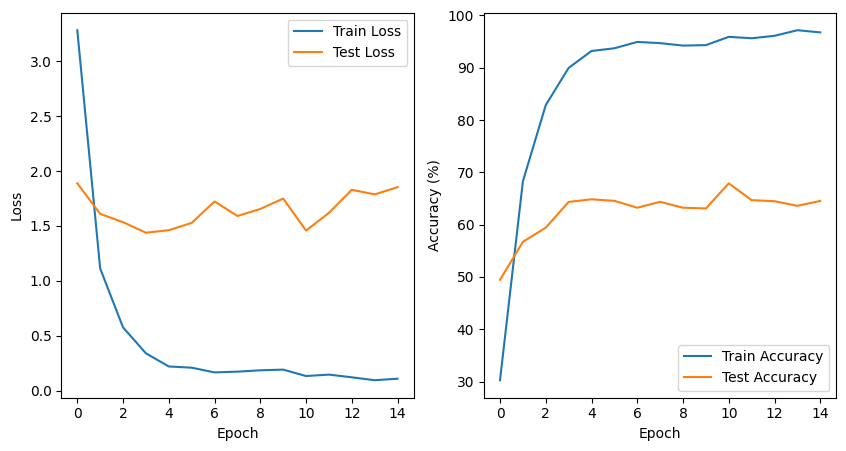

In [24]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [25]:
# saving the final model checkpoint

checkpoint_path = '/content/drive/MyDrive/model_checkpoint_efficientNet.pt'
torch.save(model.state_dict(), checkpoint_path)